All Networks and Features together

**Install Requirements**

In [ ]:
!pip install hazm
!pip install nlpaug
!pip install stanza
!pip install requests
!pip install python-bidi
!pip install transformers

     |████████████████████████████████| 316 kB 5.0 MB/s 
     |████████████████████████████████| 1.4 MB 23.9 MB/s 
     |████████████████████████████████| 233 kB 41.6 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=28de0505bdb3c048f293898c556acbad4aea2d9292d6229c1f9cb6db16d6b639
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154378 sha256=6ece4d6ed20a6109091e55bb54b73a3ec7ee9e5a4b1a7a484ef711b7a15b1719
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 405 kB 5.3 MB/s 
     |████████████████████████████████| 432 kB 5.4 MB/s 
     |█

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**Declare Required Paths**

In [ ]:
dataset_path = '/content/drive/MyDrive/Stance Detection/Own/HeadlineToClaim.csv'
stopWord_path = '/content/drive/MyDrive/Stance Detection/Own/StopWords_fa.txt'
save_load_path = "/content/drive/MyDrive/Stance Detection/Own/vectors"
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'

**Import Section**

In [ ]:
import os
import re
import time
import nltk
import random
import stanza
import string
import joblib
import pprint
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline


from hazm import *
from tqdm.notebook import tqdm
from difflib import SequenceMatcher
import nlpaug.augmenter.word as naw
from bidi.algorithm import get_display
from scipy.spatial.distance import cosine
from nltk import word_tokenize as nltk_word_tokenize

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.optim import SGD
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification , BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

**Declare Handmade Necessaries**

In [ ]:
# INPUT_PREFERENCE = 'Single sentence'
INPUT_PREFERENCE = 'Couple sentence'

ADD_EXTRA_FAETURES = True

BERT_ONLY = True

AUGMENTATION = True

if (BERT_ONLY == True):
  ADD_EXTRA_FAETURES = False

In [ ]:
fa_punctuations = ['،','«','»',':','؛','ْ','ٌ','ٍ','ُ','ِ','َ','ّ','ٓ','ٰ','-','*']
important_words = ['؟','تکذیب', 'تکذیب شد', ':',]

In [ ]:
refute_hedge_reporte_words = ['جعلی',
                   'تقلب',
                   'فریب',
                   'حیله',
                   'کلاهبرداری',
                   'شیادی',
                   'دست انداختن',
                   'گول زدن',
                   'نادرست',
                   'غلط',
                   'کذب',
                   'ساختگی',
                   'قلابی',
                   'انکار',
                   'رد',
                   'تکذیب',
                   'تکذیب کردن',
                   'تکذیب شد',
                   'انکار کردن'
                   'انکار می کند',
                   'نه',
                   'با وجود',
                   'علیرغم',
                   'با اینکه',
                   'شک داشتن',
                   'تردید کردن',
                   'مظنون بودن',
                   'شک',
                   'تردید',
                   'دو دلی',
                   'گمان',
                   'به گزارش'
                   ,'ادعا شده'
                   ,'به قول معروف'
                   ,'بنا به گفته'
                   , 'ظاهرا'
                   ,'به نظر می رسد'
                   ,'ادعا'
                   ,'میتوانست'
                   ,'می تواند'
                   ,'از قرار معلوم'
                   ,'مشخصا'
                   ,'تا حد زیادی'
                   ,'احتمال دارد'
                   ,'شاید'
                   ,'به طور عمده'
                   ,'ممکن است'
                   ,'گویا'
                   ,'ممکن'
                   ,'اغلب'
                   ,'غالبا'
                   ,'احتمالا'
                   ,'احتمالاً'
                   ,'محتملا'
                   ,'گفته شده'
                   ,'گزارش داد'
                   ,'طبق گزارش'
                   ,'شایعه'
                   ,'شایعات'
                   ,'شایعه شده'
                   ,'قدری'
                   ,'تا حدی'
                   ,'تأیید نشده'
]

In [ ]:
if (ADD_EXTRA_FAETURES == True):
  stanza.download('fa')

**Functions**

**Preproccessing Data**

In [ ]:
def clean_sentence(sentence):

  normalizer = Normalizer()
  shayee = normalizer.normalize("شایعه")
  clean_sentences = sentence
  re_pattern1 = "(/(\s)*"+ shayee +"(\s)*[0-9]+)|(/(\s)*شایعه(\s)*[0-9]+)"
  re_pattern2 = "/(\s)*[0-9]+"
  re_pattern3 = "\\u200c|\\u200d|\\u200e|\\u200b|\\u2067|\\u2069"
  x = re.search(re_pattern1, sentence)
  if (x):
    clean_sentences = re.sub(re_pattern1, "", sentence)
    
  x = re.search(re_pattern2, clean_sentences)
  if (x):
    clean_sentences = re.sub(re_pattern2, "", clean_sentences)
        
  x = re.search(re_pattern3, clean_sentences)
  if (x):
    clean_sentences = re.sub(re_pattern3, "", clean_sentences)   
        
  punc_regex = re.compile('|'.join(map(re.escape, list(string.punctuation) + list(fa_punctuations))))

  clean_sentences = punc_regex.sub("", clean_sentences)

  return clean_sentences

In [ ]:
def clean_tokens(target_list):
    assert isinstance(target_list, (list)) == True , "Type of target_list is not correct. It has to be list."
    normalizer = Normalizer()

    denide_words = fa_stop_words + list(string.punctuation) + list(fa_punctuations)
            
    clean_words = []

    for item in target_list:
      clean_words.append([i for i in item if normalizer.normalize(i) not in denide_words])
    return clean_words

**Split Dataset**

In [ ]:
def load_data(df):

    trainset = df[df.data_type=='train']

    valset = df[df.data_type=='val']

    testset = df[df.data_type=='test']

    return trainset, valset, testset

**Classes Distribution**

In [ ]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    # return "{:.1f}%\n({:d} N.)".format(pct, absolute)
    return "{:.1f}%".format(pct, absolute)

In [ ]:
def classes_distribution(df):

  First_Categories = list(set(df.stance))
  k = dict()
  for CG in list(df.stance):
    if CG not in k.keys():
      k[CG] = 1
    else:
      k[CG] += 1
  pprint.pprint(k)
  print('Number of Rows: ',sum(k.values()))

  Categories_Data = list(k.values())
  Categories = [z for z in list(k.keys())]
  Categories = [get_display(i) for i in Categories]
  # explode = (0.1, 0.0, 0.2, 0.3, 0.0, 0.0)
  colors = ( "orange", "cyan", "brown","yellow", "purple", "beige", "pink")
  wp = { 'linewidth' : 1, 'edgecolor' : "black" }

  fig, ax = plt.subplots(figsize =(12, 9))
  wedges, texts, autotexts = ax.pie(Categories_Data, 
                                    autopct = lambda pct: func(pct, Categories_Data),
                                    labels = Categories,
                                    shadow = False,
                                    # explode = explode,
                                    colors = colors,
                                    startangle = 180,
                                    wedgeprops = wp,
                                    textprops = dict(color ="black"))
    
  ax.legend(wedges, Categories,
            title ="Categories",
            loc ="center",
            bbox_to_anchor =(1.3, 0, 0.5, 1)) 
  plt.setp(autotexts, size = 8, weight ="bold")
  ax.set_title("Pie Chart of Categories")
  plt.show()


**Feature Generation**

In [ ]:
def generate_Features( data_df, save_path, load_path, save_feature = False, load_if_exist = True,
                       senteces_similarity = True, important_words = True,
                       is_question = True, more_than2_parts = True, 
                       root_distance = True, w2v = True , bow = True ,tfidf = True):
  
    features = data_df['question'].values
    features = np.reshape(features,(len(features),1))

    print(features.shape)

    hasTowParts = data_df['part'].values
    print(len(hasTowParts))
    clean_claims = data_df['clean_claim'].values
    print(len(clean_claims))
    clean_headlines = data_df['clean_headline'].values
    print(len(clean_headlines))
    clean_claims_headlines = data_df['cln_clm_hdln'].values
    print(len(clean_claims_headlines))

    print(len(clean_headlines))


    file_name = ''

    if load_if_exist == True or save_feature == True:
      if tfidf:
        file_name += 'tfidf_'
      if senteces_similarity:
        file_name += 'similarity_'
      if important_words:
        file_name += 'important_words_'        
      if is_question:
        file_name += 'is_question_'
      if more_than2_parts:
        file_name += 'more_than2_parts_'
      if root_distance:
        file_name += 'root_distance_'    
      if w2v:
        file_name += 'w2v_'     
      if bow:
        file_name += 'bow_'    


    if load_if_exist :
      assert len(load_path) > 0, "Please enter load_path."
      load_file_name = load_path + '/' + file_name + '.pkl'
      if os.path.isfile(load_file_name) == True :
        features = joblib.load(load_file_name)
        print('Features loaded successfully.')
        return features, file_name
      else:
        print('Features vector file is not exist.')
    
    # -------------- tfidf ----------
    if tfidf:
      print('Start to generate tf_idf feature')
      tf_idf_feature = tf_idf()
      features = np.append(features, tf_idf_feature ,axis = 1)
      print('End of tf_idf feature')
    # -------------- similarity ----------
    if senteces_similarity:
      print('Start to generate similarity feature')
      similarity_feature = similarity(clean_claims, clean_headlines)
      features = np.append(features, similarity_feature ,axis = 1)
      print('End of similarity feature')
    # -------------- important words ----------
    if important_words:
      print('Start to generate important words feature')
      important_words_feature = calc_important_words(clean_claims_headlines)
      features = np.append(features, important_words_feature ,axis = 1)
      print('End of important words feature')
    # -------------- is question ----------
    if is_question == False:
      features = features[:,1:]
    else:
      print('"is question" feature was added.')
    # -------------- more than tow parts ----------
    if more_than2_parts:
      features = np.append(features, np.reshape(hasTowParts, (len(hasTowParts),1)) ,axis = 1)
      print('"more than tow parts" feature was added.')
    # -------------- root distance ----------
    if root_distance:
      print('Start to generate root distance feature')
      root_distance_feature = calculate_root_distance(clean_headlines)
      features = np.append(features, root_distance_feature ,axis = 1)
      print('End of root distance feature')  
    # -------------- w2v ----------
    # if w2v:
    #   print('Start to generate w2v feature')
    #   assert len(w2v_model_path) > 0, "Please enter w2v_model_path."
    #   w2v_model = joblib.load(w2v_model_path)
    #   w2v_feature = get_w2v_feature(w2v_model, num_features = 300)
    #   w2v_feature = (w2v_feature - np.min(w2v_feature))/ (np.max(w2v_feature) - np.min(w2v_feature))
    #   features = np.append(features, w2v_feature ,axis = 1)
    #   print('End of w2v feature')   
    # -------------- bow ----------
    if bow:
      print('Start to generate bow feature')
      bow_feature = get_bow(clean_claims_headlines)
      features = np.append(features, bow_feature ,axis = 1)
      print('End of bow feature')          
    
    if save_feature:
      joblib.dump(features, (save_path + '/' + file_name + '.pkl'))
      print('Features saved successfully.')          
    return features, file_name

In [ ]:
def tf_idf():
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2))
    features = tfidf.fit_transform(clean_claims_headlines).toarray() 
    return features
  # --------------------------------------------------
def similarity(clean_claims, clean_headlines):
    feature = []
    for i, (claim,headline) in enumerate(zip(clean_claims, clean_headlines)):
      ratio = SequenceMatcher(None, claim, headline).ratio()
      quick_ratio = SequenceMatcher(None, claim, headline).quick_ratio()
      real_quick_ratio = SequenceMatcher(None, claim, headline).real_quick_ratio()
      feature.append([ratio,quick_ratio,real_quick_ratio])
    return feature    
  # --------------------------------------------------
def calc_important_words(clean_claims_headlines):
    assert (important_words != None), 'For calculating important words you should pass important words in initializer.'
    features = np.zeros((len(clean_claims_headlines), len(important_words)))
    for i in range(len(clean_claims_headlines)):
      for j in range(len(important_words)):
        if important_words[j] in clean_claims_headlines[i]:
            features[i][j] = 1
    return features
  # --------------------------------------------------
def calculate_root_distance(clean_headlines, target_sentences = None): # target_sentences = clean_headlines
    
    if target_sentences == None:
      target_sentences = clean_headlines
    
    # nlp = stanfordnlp.Pipeline(lang='fa', models_dir= self.stanford_models_path, treebank=None, use_gpu=True) 
    nlp = stanza.Pipeline(lang='fa')#, models_dir= self.stanza_models_path) #, treebank=None, use_gpu=True) 
    root_distance_feature = np.zeros((len(target_sentences),1))
    for index,headline in enumerate(target_sentences):
      root_distance_feature[index] = -1
      doc = nlp(headline)
    #   root = [(i,doc.sentences[0].words[i].text) for i in range(len(doc.sentences[0].words)) if  doc.sentences[0].words[i].dependency_relation == 'root' ]
      root = [(i,doc.sentences[0].words[i].text) for i in range(len(doc.sentences[0].words)) if  doc.sentences[0].words[i].deprel == 'root' ]
      if(len(root) == 0):
        continue

      root_index,root_word = root[0]

      for word_index,word in enumerate(headline.split()) :
        target = [(i,refute_hedge_reporte_words[i]) for i in range(len(refute_hedge_reporte_words)) if  refute_hedge_reporte_words[i] == word]
        if(len(target) > 0):
          target_index, target_word =target[0]
          root_distance_feature[index] = abs(word_index - root_index)
          break
    return root_distance_feature
  # --------------------------------------------------

def get_bow(clean_claims_headlines, target_sentences = None):
    if target_sentences == None:
      target_sentences = clean_claims_headlines
    vectorizer = CountVectorizer(ngram_range=(1, 1))
    X = vectorizer.fit_transform(target_sentences)
    return X.toarray()

In [ ]:
def create_features_tensors(df):
  
  # temp_df =  features_df[features_df.data_type==mode]
  temp_df = df.drop(['data_type'], axis=1)
  

  features_list = []
  for i in range(len(temp_df.index)):
    features_list.append(temp_df.iloc[i])

  features_tensor = torch.tensor(features_list, dtype = torch.double)
  return features_tensor

**Data Augmentation**

In [ ]:
def text_augmentor(sentences):
  
  return aug.augment(list(sentences))

**Tokenizing**

In [ ]:
def encoding_phase(data):
  if (INPUT_PREFERENCE == 'Couple sentence'):
   
    encoded_data = parsBERT_tokenizer(
        list(data['clean_claim']), 
        list(data['clean_headline']), 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=36, 
        return_tensors='pt',
        truncation=True
    )
  else:
    encoded_data = parsBERT_tokenizer.batch_encode_plus(
        list(data['cln_clm_hdln']), 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=36, 
        return_tensors='pt',
        truncation=True
    )
  return encoded_data

**Tensor Detaset**

In [ ]:
def create_tensor_dataset(data, features_df=None):

  encoded_data = encoding_phase(data)

  input_ids = encoded_data['input_ids']
  attention_masks = encoded_data['attention_mask']
  token_type_ids = encoded_data['token_type_ids']
  labels = torch.tensor(data.label.values)

  if (ADD_EXTRA_FAETURES == True):
    
    extra_features = create_features_tensors(features_df)
    return TensorDataset(input_ids, attention_masks, token_type_ids, extra_features, labels)
  
  return TensorDataset(input_ids, attention_masks, token_type_ids, labels)

**Score Calculations**

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Calculating Time**

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Create Status DataFrame**

In [ ]:
def create_status_dataFrame(training_status, lr, eps, epochs, batch_size):
  
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_status = pd.DataFrame(data=training_status)

  df_status['lr'] = lr
  df_status['eps'] = eps
  df_status['num_epochs'] = epochs
  df_status['batch size'] = batch_size


  # Use the 'epoch' as the row index.
  # df_status = df_status.set_index('Epoch')

  return df_status

**Plotting Function**

In [ ]:
def plot_evaluations(mode, df):
  
  if (mode == 'F1'):
    y_training_plt = df['Training Eval. F1']
    y_val_plt = df['Valid. F1'] 
    title_plt = "Training & Validation F1"
    y_label_plt = "F1"

  elif (mode == 'Loss'):
    y_training_plt = df['Training Loss']
    y_val_plt = df['Valid. Loss'] 
    title_plt = "Training & Validation Loss"
    y_label_plt = "Loss"

  elif (mode == 'Acc'):
    y_training_plt = df['Training Eval. Acc.']
    y_val_plt = df['Valid. Acc.'] 
    title_plt = "Training & Validation Acc."
    y_label_plt = "Accuracy"

  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(y_training_plt, 'b-o', label="Training")
  plt.plot(y_val_plt, 'g-o', label="Validation")

  # Label the plot.
  plt.title(title_plt)
  plt.xlabel("Epoch")
  plt.ylabel(y_label_plt)
  plt.legend()
  plt.xticks([1, 2, 3, 4])

  plt.show()


In [ ]:
def plot_proformance(df):
  titles = ["Loss", "Accuracy", "F1-Score"]
  fig,axes = plt.subplots(1, 3)
  fig.suptitle("Model Performance")
  fig.set_size_inches(20, 5)
  yvalues_train = [df['Training Loss'], df['Training Eval. Acc.'], df['Training Eval. F1']]
  yvalues_val = [df['Valid. Loss'], df['Valid. Acc.'], df['Valid. F1']]
  # xlabel = "Epoch"
  
  for i, ax in enumerate(axes):
    ax.plot(yvalues_train[i], 'b-o', label="Training")
    ax.plot(yvalues_val[i], 'g-o', label="Validation")
    ax.set_title(titles[i])
    # ax.xlabel("Epoch")
    ax.legend()
    ax.grid(True)
  plt.setp(axes, xlabel='Epoch')
  plt.show()

In [ ]:
def report(mode, predictions, true_vals):

  print("####### Report on ", mode, " #######")
  
  print("\nAccuracy per class:") 
  accuracy_per_class(predictions, true_vals)
  print("************************")

  preds_flat = np.argmax(predictions, axis=1).flatten()
  print("\nClassification Report: \n", classification_report(true_vals, preds_flat))
  print("************************")

  conf_mat = confusion_matrix(true_vals, preds_flat)
  print("\nConfusion Matrix: \n")
  print(conf_mat)
  print("\n")
  plt.imshow(conf_mat)

<body>      
         <h1 style="font-size:40px;"><b>Main</h1>         
      </body>

**Reading Dataset**

In [ ]:
dataset = pd.read_csv(dataset_path, encoding = 'utf-8')
claims = dataset['claim'].values
headlines = dataset['headline'].values
isQuestion = dataset['question'].values
hasTowParts = dataset['part'].values
labels = dataset['label'].values
assert (claims.shape == headlines.shape == isQuestion.shape == labels.shape == hasTowParts.shape), "The features size are not equal."
print(claims.shape , headlines.shape ,isQuestion.shape,hasTowParts.shape ,labels.shape)

(2029,) (2029,) (2029,) (2029,) (2029,)


**Reading Persian Stop Words**

In [ ]:
normalizer = Normalizer()
fa_stop_words = list()
print(stopWord_path)
with open(stopWord_path) as f:
  for line in f:
    fa_stop_words.append(normalizer.normalize(line.rstrip("\n\r")))

/content/drive/MyDrive/Stance Detection/Own/StopWords_fa.txt


**Cleaning Sentences**

In [ ]:
clean_claims = []
clean_headlines = []
for claim,headline in zip(claims, headlines):
  clean_claims.append(clean_sentence(claim))
  clean_headlines.append(clean_sentence(headline))

print(len(clean_claims))
print(len(clean_headlines))

dataset['clean_claim'] = clean_claims
dataset['clean_headline'] = clean_headlines
dataset['cln_clm_hdln'] = dataset['clean_claim'] + " " + dataset['clean_headline']
clean_claims_headlines = dataset['cln_clm_hdln']

2029
2029


**Encoding the Labels**

In [ ]:
possible_labels = dataset.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)

dataset = dataset.rename(columns = {'label':'stance'})
dataset['label'] = dataset.stance.replace(label_dict)

{'Discuss': 0, 'Unrelated': 1, 'Agree': 2, 'Disagree': 3}


**Spliting Data in Train/Test/Validation**

In [ ]:
X_train_all, X_test, y_train_all, y_test = train_test_split(dataset.index.values, 
                                                  dataset.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset.label.values)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, 
                                                  y_train_all, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=y_train_all)

In [ ]:
dataset['data_type'] = ['not_set']*dataset.shape[0]

dataset.loc[X_train, 'data_type'] = 'train'
dataset.loc[X_val, 'data_type'] = 'val'
dataset.loc[X_test, 'data_type'] = 'test'

dataset.groupby(['stance', 'label', 'data_type']).count()

index  claim  ...  clean_headline  cln_clm_hdln
stance    label data_type                ...                              
Agree     2     test          61     61  ...              61            61
                train        292    292  ...             292           292
                val           52     52  ...              52            52
Disagree  3     test          25     25  ...              25            25
                train        118    118  ...             118           118
                val           21     21  ...              21            21
Discuss   0     test         120    120  ...             120           120
                train        580    580  ...             580           580
                val          102    102  ...             102           102
Unrelated 1     test          99     99  ...              99            99
                train        475    475  ...             475           475
                val           84     84  ...              84            84

[12 rows x 9 columns]

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

1465
259
305


**Extracting Extra Feature --- Original Data**

In [ ]:
if (ADD_EXTRA_FAETURES == True):
  features, file_name = generate_Features(dataset, save_path=save_load_path, load_path=save_load_path, save_feature = True, load_if_exist = True, 
                              senteces_similarity = True, important_words = True,
                              is_question = True, more_than2_parts = True, 
                              root_distance = True, w2v = False , bow = True ,tfidf = False)
  print(features.shape)
  print(file_name)

In [ ]:
if (ADD_EXTRA_FAETURES == True):
  features_df = pd.DataFrame(features)
  features_df['data_type'] = dataset['data_type']
  features_df.info()

**Load Data in different Datasets**

In [ ]:
train_dataset, val_dataset, test_dataset = load_data(dataset)

**Data Augmentation**

In [ ]:
if (AUGMENTATION == True):
  aug = naw.ContextualWordEmbsAug(model_path=MODEL_NAME_OR_PATH, action="insert")

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

In [ ]:
if (AUGMENTATION == True):
  print("Classes distribution before augmentation on train set:")
  classes_distribution(train_dataset)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_claim     118 non-null    object
 1   clean_headline  118 non-null    object
 2   cln_clm_hdln    118 non-null    object
 3   question        118 non-null    int64 
 4   part            118 non-null    int64 
 5   stance          118 non-null    object
 6   label           118 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 6.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1465 entries, 0 to 2028
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_claim     1465 non-null   object
 1   clean_headline  1465 non-null   object
 2   cln_clm_hdln    1465 non-null   object
 3   question        1465 non-null   int64 
 4   part            1465 non-null   int64 
 5   stance          1465 non-null  

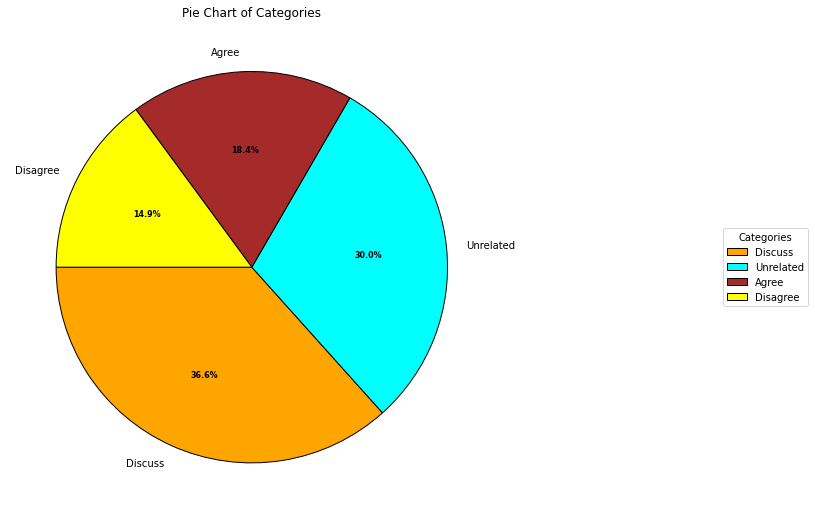

In [ ]:
if (AUGMENTATION == True):
  disagree_train_df = train_dataset[train_dataset.stance =='Disagree']

  disagree_dataset = pd.DataFrame()
  disagree_dataset ['clean_claim'] = text_augmentor(disagree_train_df['clean_claim'])
  disagree_dataset ['clean_headline'] = text_augmentor(disagree_train_df['clean_headline'])
  disagree_dataset ['cln_clm_hdln'] = text_augmentor(disagree_train_df['cln_clm_hdln'])
  disagree_dataset ['question'] = disagree_train_df['question'].values
  disagree_dataset ['part'] = disagree_train_df['part'].values
  disagree_dataset ['stance'] = 'Disagree'
  disagree_dataset ['label'] = 3
  disagree_dataset.info()

  train_temp_df = pd.DataFrame()
  train_temp_df ['clean_claim'] = train_dataset['clean_claim']
  train_temp_df ['clean_headline'] = train_dataset['clean_headline']
  train_temp_df ['cln_clm_hdln'] = train_dataset['cln_clm_hdln']
  train_temp_df ['question'] = train_dataset['question']
  train_temp_df ['part'] = train_dataset['part']
  train_temp_df ['stance'] = train_dataset['stance']
  train_temp_df ['label'] = train_dataset['label']
  train_temp_df.info()

  frames = [train_temp_df, disagree_dataset]
  train_dataset = pd.concat(frames)
  print(train_dataset.info())

  print("Classes distribution after augmentation on train set:")
  classes_distribution(train_dataset)

In [ ]:
disagree_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_claim     118 non-null    object
 1   clean_headline  118 non-null    object
 2   cln_clm_hdln    118 non-null    object
 3   question        118 non-null    int64 
 4   part            118 non-null    int64 
 5   stance          118 non-null    object
 6   label           118 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 6.6+ KB


In [ ]:
if (AUGMENTATION == True):
  if (ADD_EXTRA_FAETURES == True):
    features_augmented_data, file_name_aug = generate_Features(disagree_dataset,
                                save_path=save_load_path, load_path=save_load_path,
                                save_feature = False, load_if_exist = False, 
                                senteces_similarity = True, important_words = True,
                                is_question = True, more_than2_parts = True, 
                                root_distance = True, w2v = False , bow = True ,tfidf = False)
    print(features_augmented_data.shape)
    print(file_name_aug)

    features_augmented_df = pd.DataFrame(features_augmented_data)
    features_augmented_df['data_type'] = 'train'
    features_augmented_df.info()


**Tokenizing**

In [ ]:
parsBERT_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

**Create Tensor Dataset**

In [ ]:
if ( ADD_EXTRA_FAETURES == True):
  train_features_df, val_features_df, test_features_df = load_data(features_df)
  if (AUGMENTATION == True):
    frames = [train_features_df, features_augmented_df]
    train_features_df = pd.concat(frames)

    train_data = create_tensor_dataset(train_dataset, train_features_df)
    val_data = create_tensor_dataset(val_dataset, val_features_df)
    test_data = create_tensor_dataset(test_dataset, test_features_df)
else:
  train_data = create_tensor_dataset(train_dataset)
  val_data = create_tensor_dataset(val_dataset)
  test_data = create_tensor_dataset(test_dataset)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing

In [ ]:
# train_data = create_tensor_dataset(train_dataset, train_features_df)
# val_data = create_tensor_dataset(val_dataset, val_features_df)
# test_data = create_tensor_dataset(test_dataset, test_features_df)

<h1> Models </h1>


In [ ]:
if ( ADD_EXTRA_FAETURES == True):
  FEATURES_LENGTH = len(features_df.columns) - 1
  inputs_length = 768 + FEATURES_LENGTH # BERT outpus plus extracted features
  n_classes = 4

**Model's Functions**

In [ ]:
def prepare_dataloaders(batch_size):
  dataloader_train = DataLoader(train_data, 
                                sampler=RandomSampler(train_data), 
                                batch_size=batch_size)

  dataloader_validation = DataLoader(val_data, 
                                    sampler=SequentialSampler(val_data), 
                                    batch_size=batch_size)

  dataloader_test = DataLoader(test_data, 
                                    sampler=SequentialSampler(test_data), 
                                    batch_size=batch_size)
  return dataloader_train, dataloader_validation, dataloader_test

**Model: BERT Only**

In [ ]:
def evaluate(model, dataloader_val):

    t0 = time.time()

    # print("Start Evaluating...")

    model.eval()
    
    loss_val_total = 0
    # total_eval_accuracy = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        if (INPUT_PREFERENCE == 'Couple sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels':         batch[3]
                  }
        elif (INPUT_PREFERENCE == 'Single sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2]
                  }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        # total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    validation_time = format_time(time.time() - t0)

    # print("Evaluation is done!")

    return loss_val_avg, predictions, true_vals, validation_time

In [ ]:
def train_model(learning_rate, optimizer_name, epsilon, epochs, batch_size):

  training_status = []

  torch.cuda.empty_cache()

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
  print("----------------------------------------------------------------")
  print("\n\n\nLoading model is done!")
  
  dataloader_train, dataloader_validation, dataloader_test = prepare_dataloaders(batch_size)

  print("DataLoader declaration is done!")

  if (optimizer_name == 'AdamW'):
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  
  elif (optimizer_name == 'SGD'):
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  # optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  print("Optimizer was selected!")

  # scheduler = get_linear_schedule_with_warmup(optimizer, 
  #                                             num_warmup_steps=0,
  #                                             num_training_steps=len(dataloader_train)*epochs)
  # print("Schedular is set!")

  model.to(device)

  print("\nStart Training...")

  total_t0 = time.time()

  for epoch in tqdm(range(1, epochs+1)):
    
    t0 = time.time()

    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        if (INPUT_PREFERENCE == 'Couple sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels':         batch[3]
                  }
        elif (INPUT_PREFERENCE == 'Single sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2]
                  }     

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        # scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    training_time = format_time(time.time() - t0)

    # torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            

    train_eval_loss, train_eval_predictions, train_true_vals, train_eval_time = evaluate(model, dataloader_train)
    train_eval_f1 = f1_score_func(train_eval_predictions, train_true_vals)
    train_eval_acc = flat_accuracy(train_eval_predictions, train_true_vals)
    
    val_loss, predictions, true_vals, validation_time = evaluate(model, dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = flat_accuracy(predictions, true_vals)

    tqdm.write(f'\nTraining loss: {loss_train_avg}')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Training eval Acc.: {train_eval_acc}')
    tqdm.write(f'Validation Acc.: {val_acc}')
    tqdm.write(f'Training eval F1 Score (Weighted): {train_eval_f1}')
    tqdm.write(f'Validation F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Training this epoch took: {training_time}')
    
    training_status.append(
        {
            'Epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Training Eval. Acc.': train_eval_acc,
            'Valid. Acc.': val_acc,
            'Training Eval. F1': train_eval_f1,
            'Valid. F1': val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    
  print("Training Done!")
  print("Total training took {:} (h:mm:ss)\n\n\n".format(format_time(time.time()-total_t0)))
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")
  return training_status, predictions, true_vals, dataloader_test, model

**Model: BERT + MLP**

In [ ]:
class StanceClasiifier(nn.Module):

  def __init__(self, bert_model):
    
    super().__init__()
    self.hidden1 = nn.Linear(inputs_length, 700)
    self.hidden2 = nn.Linear(700, 700)
    # self.hidden3 = nn.Linear(700, 700)
    self.output = nn.Linear(700, n_classes)

    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    # self.relu3 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.5)
    self.dropout2 = nn.Dropout(p=0.5)
    # self.dropout3 = nn.Dropout(p=0.5)
    # self.batchnorm1 = nn.BatchNorm1d(700)
    self.bert = bert_model

  def forward(self, x):
    x = self.hidden1(x)
    # x = self.batchnorm1(x)
    x = self.dropout1(x)
    x = self.relu1(x)
    x = self.hidden2(x)
    x = self.dropout2(x)
    x = self.relu2(x)
    # x = self.hidden3(x)
    # x = self.dropout3(x)
    # x = self.relu3(x)

    x = self.output(x)
    return x


In [ ]:
def evaluate_BERT_MLP(model, dataloader_val, loss_function):

    t0 = time.time()

    print("Start Evaluating...")

    model.eval()
    
    loss_val_total = 0
    # total_eval_accuracy = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        input_ids, attention_mask, token_type_ids, extra_features, labels = tuple(b.to(device) for b in batch)

        with torch.no_grad():        
            output = model.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            embeddings = output[1][0]
            embeddings = embeddings.mean(dim=1).double() 

            features_comb = torch.cat((embeddings, extra_features), dim=1)

            outputs = model(features_comb)

            loss = loss_function(outputs, labels)
            loss_val_total += loss

        logits = outputs.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()    
        predictions.append(logits)
        true_vals.append(label_ids)
        
        # total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    validation_time = format_time(time.time() - t0)

    # print("Evaluation is done!")

    return loss_val_avg, predictions, true_vals, validation_time

In [ ]:
def train_BERT_MLP_model(learning_rate, optimizer_name, epsilon, epochs, batch_size):

  training_status = []

  torch.cuda.empty_cache()

  config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH, num_labels=len(label_dict), output_hidden_states=True)
  bert = BertForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, config=config)
  bert.to(device)
  print("----------------------------------------------------------------")
  print("\n\n\nLoading model is done!")

  model = StanceClasiifier(bert)
  model.double().to(device)
  
  
  dataloader_train, dataloader_validation, dataloader_test = prepare_dataloaders(batch_size)
  print("DataLoader declaration is done!")

  loss_function = nn.CrossEntropyLoss()
  print("Loss Function was declared!")

  if (optimizer_name == 'AdamW'):
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  
  elif (optimizer_name == 'SGD'):
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  # optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  print("Optimizer was selected!")

  # scheduler = get_linear_schedule_with_warmup(optimizer, 
  #                                             num_warmup_steps=0,
  #                                             num_training_steps=len(dataloader_train)*epochs)
  # print("Schedular is set!")

  # model.to(device)

  print("\nStart Training...")

  total_t0 = time.time()

  for epoch in tqdm(range(1, epochs+1)):
    
    t0 = time.time()

    model.train()
    
    loss_train_total = 0
    train_accuracy = 0
    predictions, true_vals = [], []

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        input_ids, attention_mask, token_type_ids, extra_features, labels = tuple(b.to(device) for b in batch)

        optimizer.zero_grad()

        # Run input IDs and masks through BERT first to get embeddings
        # then combine with BOW to run through rest of nnet model
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # output[1] are the hidden states.
        embeddings = outputs[1][0]
        embeddings = embeddings.mean(dim=1).double() 
        # print("embedding shape: ", embeddings.size())

        features_comb = torch.cat((embeddings, extra_features), dim=1)
        # print("features shape: ", features_comb.size())

        outputs = model(features_comb)
        vals, inds = torch.max(outputs, dim=1)
        
        loss = loss_function(outputs, labels)
        loss_train_total += loss
        
        # outputs = outputs.detach().cpu().numpy()
        # labels = labels.cpu().numpy()
        # predictions.append(outputs)
        # true_vals.append(labels)

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss/len(batch))})
         
        
    training_time = format_time(time.time() - t0)

    # torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)

    train_eval_loss, train_eval_predictions, train_true_vals, train_eval_time = evaluate_BERT_MLP(model, dataloader_train, loss_function)
    train_eval_f1 = f1_score_func(train_eval_predictions, train_true_vals)
    train_eval_acc = flat_accuracy(train_eval_predictions, train_true_vals)
    
    val_loss, predictions, true_vals, validation_time = evaluate_BERT_MLP(model, dataloader_validation, loss_function)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = flat_accuracy(predictions, true_vals)

    tqdm.write(f'\nTraining loss: {loss_train_avg}')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Training eval Acc.: {train_eval_acc}')
    tqdm.write(f'Validation Acc.: {val_acc}')
    tqdm.write(f'Training eval F1 Score (Weighted): {train_eval_f1}')
    tqdm.write(f'Validation F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Training this epoch took: {training_time}')
    
    training_status.append(
        {
            'Epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Training Eval. Acc.': train_eval_acc,
            'Valid. Acc.': val_acc,
            'Training Eval. F1': train_eval_f1,
            'Valid. F1': val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    
  print("Training Done!")
  print("Total training took {:} (h:mm:ss)\n\n\n".format(format_time(time.time()-total_t0)))
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")
  return training_status, predictions, true_vals, dataloader_test, model, loss_function

**Models Run Function -- For easy run**

In [ ]:
def run_model():

  if (BERT_ONLY == True):
    model_choice = 'BERT'
  else:
    model_choice = 'BERT + MLP'
  configuration = {
                'Model': model_choice,    
                'Optimizer': optimizer_choice,
                'Epochs': number_of_epochs,
                'Batch size': batch_size,
                'Learning rate': lr,
                'Momentum/Eps': eps 
            }
  
  print(configuration)
  if (BERT_ONLY == True):
    training_status, predictions, true_vals, dataloader_test, model = train_model(learning_rate=lr,
                                                                                  optimizer_name=optimizer_choice,
                                                                                  epsilon=eps,
                                                                                  epochs=number_of_epochs,
                                                                                  batch_size=batch_size)

  else:
    training_status, predictions, true_vals, dataloader_test, model, loss_function = train_BERT_MLP_model(
                                                                                  learning_rate=lr,
                                                                                  optimizer_name=optimizer_choice,
                                                                                  epsilon=eps,
                                                                                  epochs=number_of_epochs,
                                                                                  batch_size=batch_size)
    
  df_status = create_status_dataFrame(training_status, lr=lr, eps=eps, epochs=number_of_epochs, batch_size=batch_size)
  plot_proformance(df_status)
  report("Validation", predictions, true_vals)
  
  if (BERT_ONLY == True):
    test_report(model, dataloader_test)
  else:
    test_report(model, dataloader_test, loss_function)

  return training_status, predictions, true_vals, dataloader_test, model

In [ ]:
def test_report(model, dataloader_test, loss_function=None):
  if (BERT_ONLY == True):
    test_loss, predictions_test, true_vals_test, test_time = evaluate(model, dataloader_test)
  else:
    test_loss, predictions_test, true_vals_test, test_time = evaluate_BERT_MLP(model, dataloader_test, loss_function)
  
  test_f1 = f1_score_func(predictions_test, true_vals_test)
  test_acc = flat_accuracy(predictions_test, true_vals_test)
  print("loss on test set: ", test_loss)
  print("f1 on test set: ", test_f1)
  print("acc on test set: ", test_acc)

**Run Models**

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 4, 'Learning rate': 6.162137446893566e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.0649852649581553
Validation loss: 0.789872763477839
Training eval Acc.: 0.8243840808591283
Validation Acc.: 0.6872586872586872
Training eval F1 Score (Weighted): 0.8251401280130735
Validation F1 Score (Weighted): 0.686821300187195
Training this epoch took: 0:01:24


Epoch 2:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 2

Training loss: 0.5624688610792009
Validation loss: 0.8728608071517486
Training eval Acc.: 0.9039797852179406
Validation Acc.: 0.722007722007722
Training eval F1 Score (Weighted): 0.9045208464346283
Validation F1 Score (Weighted): 0.7221224959825171
Training this epoch took: 0:01:23


Epoch 3:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.38767146039048606
Validation loss: 1.1849902473067722
Training eval Acc.: 0.952621604548326
Validation Acc.: 0.749034749034749
Training eval F1 Score (Weighted): 0.9527731628074046
Validation F1 Score (Weighted): 0.74854723706385
Training this epoch took: 0:01:23


Epoch 4:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.24067323476268976
Validation loss: 1.3688054099464073
Training eval Acc.: 0.9778900821225521
Validation Acc.: 0.749034749034749
Training eval F1 Score (Weighted): 0.977848282425927
Validation F1 Score (Weighted): 0.7485650898072559
Training this epoch took: 0:01:21


Epoch 5:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.13170483844243625
Validation loss: 1.548560231527797
Training eval Acc.: 0.9898926089703095
Validation Acc.: 0.7644787644787645
Training eval F1 Score (Weighted): 0.9898858629986423
Validation F1 Score (Weighted): 0.7641487321933272
Training this epoch took: 0:01:20


Epoch 6:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.07141345132321926
Validation loss: 1.7141632044909505
Training eval Acc.: 0.9949463044851548
Validation Acc.: 0.7760617760617761
Training eval F1 Score (Weighted): 0.9949496974641143
Validation F1 Score (Weighted): 0.7762516698909491
Training this epoch took: 0:01:19


Epoch 7:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.05661932833739992
Validation loss: 1.773560034507178
Training eval Acc.: 0.9949463044851548
Validation Acc.: 0.7606177606177607
Training eval F1 Score (Weighted): 0.9949486432753581
Validation F1 Score (Weighted): 0.7605699833619028
Training this epoch took: 0:01:19


Epoch 8:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.04694144509957911
Validation loss: 1.9905239520166875
Training eval Acc.: 0.9974731522425774
Validation Acc.: 0.7567567567567568
Training eval F1 Score (Weighted): 0.9974727939675385
Validation F1 Score (Weighted): 0.7569040175814845
Training this epoch took: 0:01:19
Training Done!
Total training took 0:12:59 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




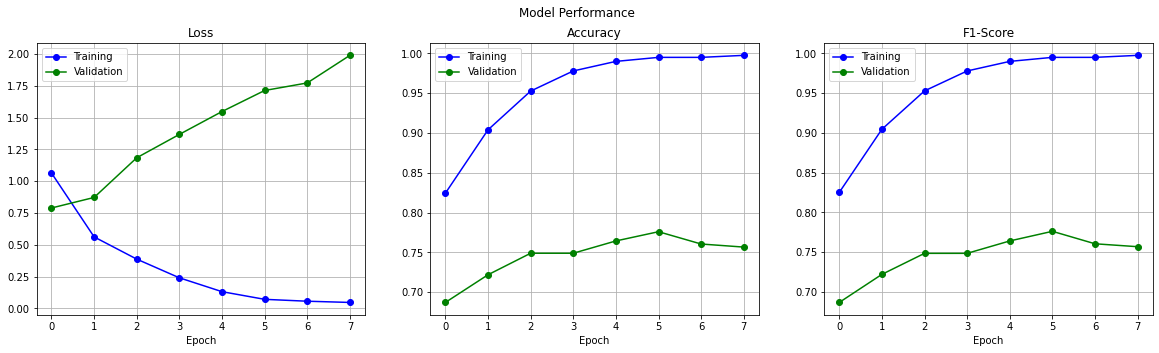

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 75/102

Class: Unrelated
Accuracy: 68/84

Class: Agree
Accuracy: 39/52

Class: Disagree
Accuracy: 14/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.74      0.77       102
           1       0.71      0.81      0.76        84
           2       0.74      0.75      0.74        52
           3       0.78      0.67      0.72        21

    accuracy                           0.76       259
   macro avg       0.76      0.74      0.75       259
weighted avg       0.76      0.76      0.76       259

************************

Confusion Matrix: 

[[75 20  6  1]
 [ 7 68  7  2]
 [ 5  7 39  1]
 [ 5  1  1 14]]


loss on test set:  1.9370636994003276
f1 on test set:  0.7564722019424348
acc on test set:  0.7573770491803279


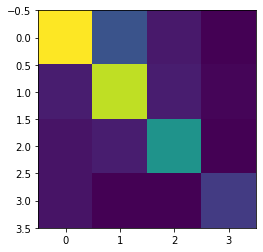

In [ ]:
# without schedular
lr=6.162137446893566e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=4

training_status, predictions, true_vals, dataloader_test, model = run_model()

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 4, 'Learning rate': 6.162137446893566e-05, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!
Schedular is set!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.09420713710815
Validation loss: 0.8788778046002754
Training eval Acc.: 0.7346809854706254
Validation Acc.: 0.640926640926641
Training eval F1 Score (Weighted): 0.7329622545680402
Validation F1 Score (Weighted): 0.6350594853588866
Training this epoch took: 0:01:24


Epoch 2:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 2

Training loss: 0.8393054629389122
Validation loss: 1.303917170645526
Training eval Acc.: 0.8553379658875553
Validation Acc.: 0.6602316602316602
Training eval F1 Score (Weighted): 0.8536760659454276
Validation F1 Score (Weighted): 0.6571661122744714
Training this epoch took: 0:01:22


Epoch 3:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.6242971473509878
Validation loss: 1.4358916916239721
Training eval Acc.: 0.9210360075805433
Validation Acc.: 0.7142857142857143
Training eval F1 Score (Weighted): 0.9203046647435342
Validation F1 Score (Weighted): 0.7116680434388045
Training this epoch took: 0:01:22


Epoch 4:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.3986432376544631
Validation loss: 1.3288707095771455
Training eval Acc.: 0.9627289955780164
Validation Acc.: 0.7335907335907336
Training eval F1 Score (Weighted): 0.96261853461521
Validation F1 Score (Weighted): 0.7336940903872007
Training this epoch took: 0:01:21


Epoch 5:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.20021180650957207
Validation loss: 1.3978885292550192
Training eval Acc.: 0.9848389134554643
Validation Acc.: 0.7606177606177607
Training eval F1 Score (Weighted): 0.9848128280512816
Validation F1 Score (Weighted): 0.7604174171876654
Training this epoch took: 0:01:21


Epoch 6:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.10179560856634665
Validation loss: 1.8013327091435294
Training eval Acc.: 0.9949463044851548
Validation Acc.: 0.7374517374517374
Training eval F1 Score (Weighted): 0.9949279138517606
Validation F1 Score (Weighted): 0.7381281272229565
Training this epoch took: 0:01:20


Epoch 7:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.029029240091753162
Validation loss: 1.7991530403803784
Training eval Acc.: 0.9974731522425774
Validation Acc.: 0.7451737451737451
Training eval F1 Score (Weighted): 0.9974699588754175
Validation F1 Score (Weighted): 0.7451583232635024
Training this epoch took: 0:01:19


Epoch 8:   0%|          | 0/396 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.02329320112201256
Validation loss: 1.7228297901993546
Training eval Acc.: 0.998104864181933
Validation Acc.: 0.7606177606177607
Training eval F1 Score (Weighted): 0.9981035709813999
Validation F1 Score (Weighted): 0.7605957298094763
Training this epoch took: 0:01:19
Training Done!
Total training took 0:12:57 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




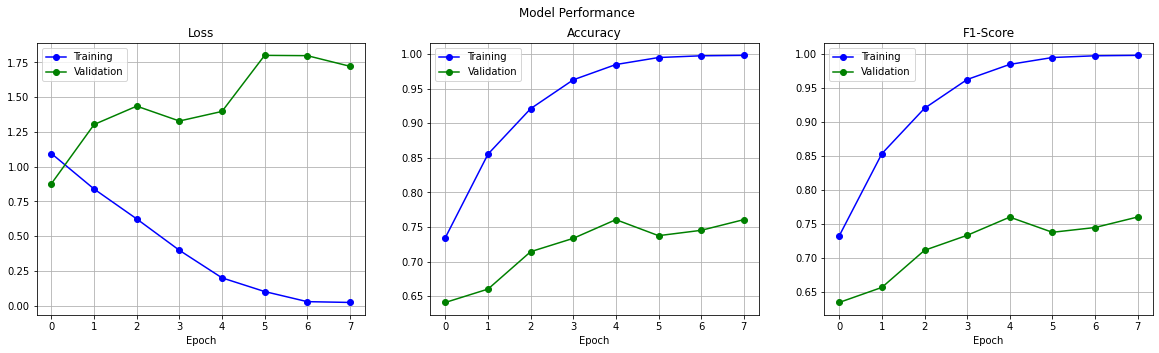

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 79/102

Class: Unrelated
Accuracy: 65/84

Class: Agree
Accuracy: 38/52

Class: Disagree
Accuracy: 15/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.77      0.76       102
           1       0.78      0.77      0.78        84
           2       0.73      0.73      0.73        52
           3       0.79      0.71      0.75        21

    accuracy                           0.76       259
   macro avg       0.76      0.75      0.76       259
weighted avg       0.76      0.76      0.76       259

************************

Confusion Matrix: 

[[79 13  6  4]
 [13 65  6  0]
 [10  4 38  0]
 [ 3  1  2 15]]


loss on test set:  2.2133166325027607
f1 on test set:  0.7012007324998094
acc on test set:  0.7016393442622951


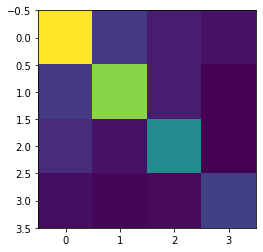

In [ ]:
# with schedular
lr=6.162137446893566e-05
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=4

training_status_sch, predictions_sch, true_vals_sch, dataloader_test_sch, model_sch = run_model()

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 6, 'Batch size': 16, 'Learning rate': 3.714160131899854e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!
Schedular is set!

Start Training...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.257895012094517
Validation loss: 1.073503413621117
Training eval Acc.: 0.5413771320277954
Validation Acc.: 0.5444015444015444
Training eval F1 Score (Weighted): 0.4448628708891149
Validation F1 Score (Weighted): 0.4590729054898223
Training this epoch took: 0:00:32


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 1.0681675720696497
Validation loss: 0.9426290515591117
Training eval Acc.: 0.5982312065698042
Validation Acc.: 0.5752895752895753
Training eval F1 Score (Weighted): 0.5095868044893104
Validation F1 Score (Weighted): 0.49619356198303566
Training this epoch took: 0:00:32


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.896700898204187
Validation loss: 0.861731569556629
Training eval Acc.: 0.6670878079595705
Validation Acc.: 0.6138996138996139
Training eval F1 Score (Weighted): 0.6202519800551791
Validation F1 Score (Weighted): 0.5568185240626196
Training this epoch took: 0:00:31


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.7725742537565906
Validation loss: 0.7966016101486543
Training eval Acc.: 0.8022741629816803
Validation Acc.: 0.6756756756756757
Training eval F1 Score (Weighted): 0.800856032841253
Validation F1 Score (Weighted): 0.6614335590174033
Training this epoch took: 0:00:32


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.6780142449971401
Validation loss: 0.7690762325244791
Training eval Acc.: 0.8281743524952622
Validation Acc.: 0.7027027027027027
Training eval F1 Score (Weighted): 0.8285133859427238
Validation F1 Score (Weighted): 0.6996824978152634
Training this epoch took: 0:00:32


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.6357542845335874
Validation loss: 0.761372009620947
Training eval Acc.: 0.8300694883133292
Validation Acc.: 0.7065637065637066
Training eval F1 Score (Weighted): 0.8303445341166407
Validation F1 Score (Weighted): 0.7048652610107449
Training this epoch took: 0:00:32
Training Done!
Total training took 0:04:02 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




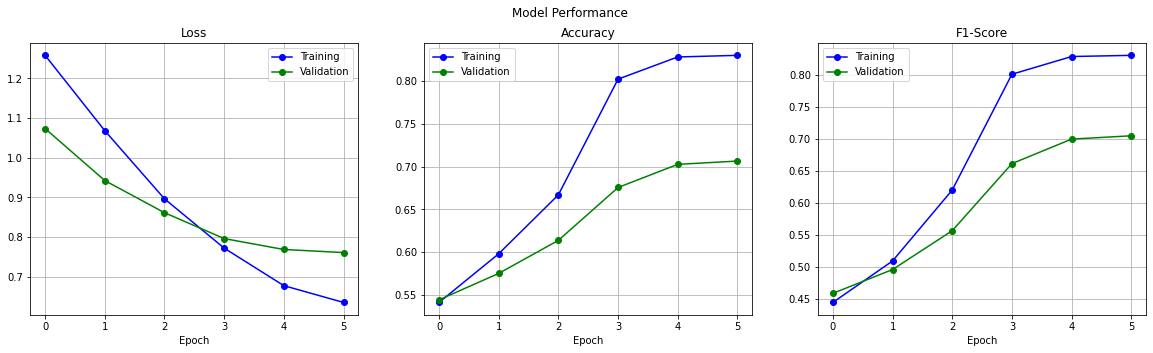

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 76/102

Class: Unrelated
Accuracy: 63/84

Class: Agree
Accuracy: 33/52

Class: Disagree
Accuracy: 11/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.75      0.71       102
           1       0.72      0.75      0.73        84
           2       0.75      0.63      0.69        52
           3       0.69      0.52      0.59        21

    accuracy                           0.71       259
   macro avg       0.71      0.66      0.68       259
weighted avg       0.71      0.71      0.70       259

************************

Confusion Matrix: 

[[76 16  7  3]
 [16 63  3  2]
 [11  8 33  0]
 [ 8  1  1 11]]


loss on test set:  0.8028903484344483
f1 on test set:  0.7198684618373459
acc on test set:  0.7213114754098361


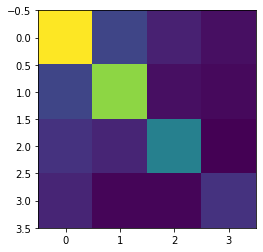

In [ ]:
# with schedular
lr=3.714160131899854e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=6
batch_size=16

training_status_sch_2, predictions_sch_2, true_vals_sch_2, dataloader_test_sch_2, model_sch_2 = run_model()

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 16, 'Learning rate': 3.714160131899854e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!
Schedular is set!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.2452775968445673
Validation loss: 1.073637727428885
Training eval Acc.: 0.5464308275426406
Validation Acc.: 0.5482625482625483
Training eval F1 Score (Weighted): 0.4542368679153048
Validation F1 Score (Weighted): 0.46782392818798996
Training this epoch took: 0:00:32


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 1.04220848854142
Validation loss: 0.9912886339075425
Training eval Acc.: 0.6001263423878711
Validation Acc.: 0.5637065637065637
Training eval F1 Score (Weighted): 0.5129731368476768
Validation F1 Score (Weighted): 0.4795665988446957
Training this epoch took: 0:00:32


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.8897497672023196
Validation loss: 0.9300030014094185
Training eval Acc.: 0.693619709412508
Validation Acc.: 0.5945945945945946
Training eval F1 Score (Weighted): 0.6611281189586593
Validation F1 Score (Weighted): 0.5446498801412097
Training this epoch took: 0:00:32


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.7942171777137602
Validation loss: 0.8663290546220892
Training eval Acc.: 0.8098547062539482
Validation Acc.: 0.6640926640926641
Training eval F1 Score (Weighted): 0.8081806492485827
Validation F1 Score (Weighted): 0.6608240562330606
Training this epoch took: 0:00:32


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.6714453155344183
Validation loss: 0.8246190679423949
Training eval Acc.: 0.8382817435249527
Validation Acc.: 0.6872586872586872
Training eval F1 Score (Weighted): 0.8375732329830158
Validation F1 Score (Weighted): 0.686820515096377
Training this epoch took: 0:00:32


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.5992659369502404
Validation loss: 0.8036127590081271
Training eval Acc.: 0.8540745420088439
Validation Acc.: 0.6988416988416989
Training eval F1 Score (Weighted): 0.8542321551025546
Validation F1 Score (Weighted): 0.6994416189469289
Training this epoch took: 0:00:32


Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.5552553648900505
Validation loss: 0.7951628732330659
Training eval Acc.: 0.866708780795957
Validation Acc.: 0.6833976833976834
Training eval F1 Score (Weighted): 0.8664970282531755
Validation F1 Score (Weighted): 0.6835424319034561
Training this epoch took: 0:00:32


Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.5242775257187661
Validation loss: 0.7921522965326029
Training eval Acc.: 0.8679722046746684
Validation Acc.: 0.6911196911196911
Training eval F1 Score (Weighted): 0.8677100108473165
Validation F1 Score (Weighted): 0.6913032699703945
Training this epoch took: 0:00:32
Training Done!
Total training took 0:05:23 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




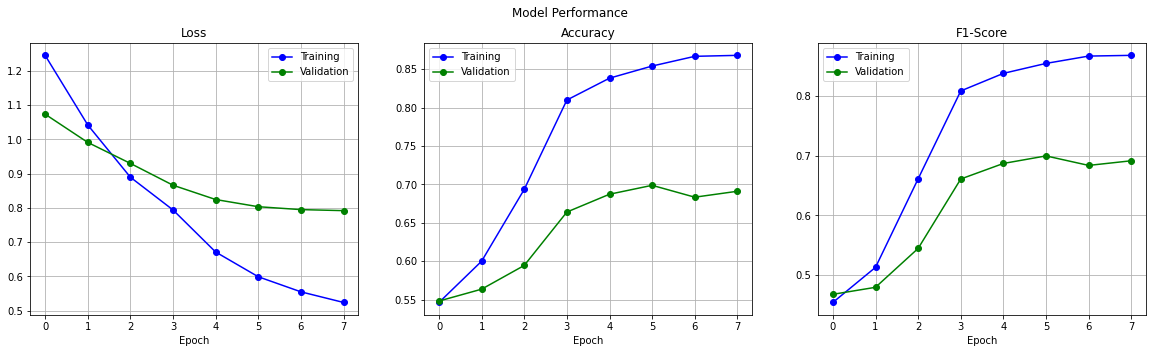

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 72/102

Class: Unrelated
Accuracy: 63/84

Class: Agree
Accuracy: 31/52

Class: Disagree
Accuracy: 13/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.71      0.68       102
           1       0.68      0.75      0.72        84
           2       0.86      0.60      0.70        52
           3       0.65      0.62      0.63        21

    accuracy                           0.69       259
   macro avg       0.71      0.67      0.68       259
weighted avg       0.70      0.69      0.69       259

************************

Confusion Matrix: 

[[72 21  4  5]
 [18 63  1  2]
 [14  7 31  0]
 [ 7  1  0 13]]


loss on test set:  0.7876056030392646
f1 on test set:  0.7202013854385289
acc on test set:  0.7213114754098361


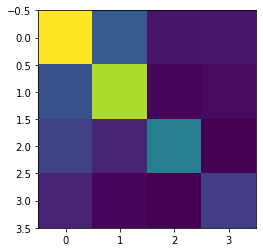

In [ ]:
# with schedular
lr=3.714160131899854e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_sch_3, predictions_sch_3, true_vals_sch_3, dataloader_test_sch_3, model_sch_3 = run_model()

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 16, 'Learning rate': 3.714160131899854e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.2698285134151728
Validation loss: 1.0485760078710669
Training eval Acc.: 0.5388502842703727
Validation Acc.: 0.5482625482625483
Training eval F1 Score (Weighted): 0.439458906447348
Validation F1 Score (Weighted): 0.46768719538043946
Training this epoch took: 0:00:32


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 1.0198055547897262
Validation loss: 0.9155028024140526
Training eval Acc.: 0.677195198989261
Validation Acc.: 0.6061776061776062
Training eval F1 Score (Weighted): 0.641961794662518
Validation F1 Score (Weighted): 0.5660507101057789
Training this epoch took: 0:00:32


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.809907137444525
Validation loss: 0.7758157568819383
Training eval Acc.: 0.815540113708149
Validation Acc.: 0.6988416988416989
Training eval F1 Score (Weighted): 0.8161497892136644
Validation F1 Score (Weighted): 0.6971412987069351
Training this epoch took: 0:00:32


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.6001512522649284
Validation loss: 0.7354924617444768
Training eval Acc.: 0.8761844598862919
Validation Acc.: 0.7181467181467182
Training eval F1 Score (Weighted): 0.8757353132746253
Validation F1 Score (Weighted): 0.7179654178867397
Training this epoch took: 0:00:32


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.46596538809814836
Validation loss: 0.7203382258029545
Training eval Acc.: 0.9102969046114971
Validation Acc.: 0.7258687258687259
Training eval F1 Score (Weighted): 0.9104212150894059
Validation F1 Score (Weighted): 0.7258584666862644
Training this epoch took: 0:00:32


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.3778218672883631
Validation loss: 0.719240750240929
Training eval Acc.: 0.9450410612760581
Validation Acc.: 0.7335907335907336
Training eval F1 Score (Weighted): 0.9449762539500262
Validation F1 Score (Weighted): 0.733079559312253
Training this epoch took: 0:00:32


Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.28478425124076884
Validation loss: 0.7249937259099063
Training eval Acc.: 0.967150979153506
Validation Acc.: 0.7451737451737451
Training eval F1 Score (Weighted): 0.9671604203855197
Validation F1 Score (Weighted): 0.7447861128220563
Training this epoch took: 0:00:31


Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.20443518121134152
Validation loss: 0.7628697209498462
Training eval Acc.: 0.967150979153506
Validation Acc.: 0.7606177606177607
Training eval F1 Score (Weighted): 0.9673596314972657
Validation F1 Score (Weighted): 0.7605672652207306
Training this epoch took: 0:00:32
Training Done!
Total training took 0:05:24 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




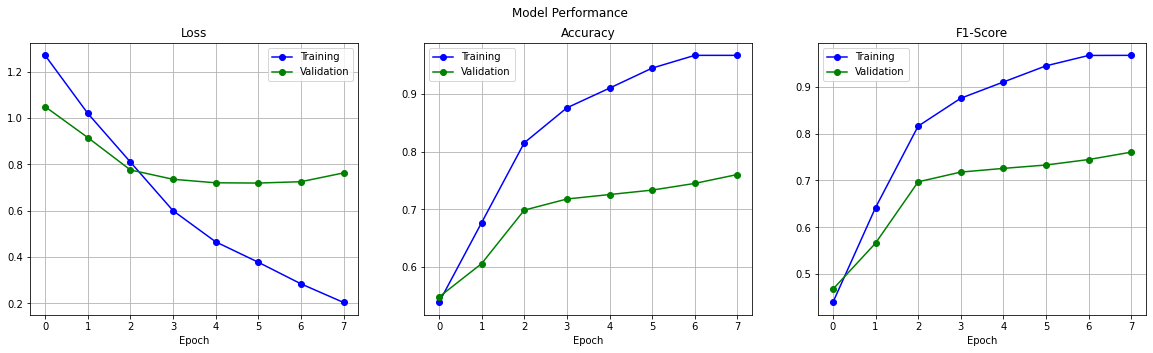

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 77/102

Class: Unrelated
Accuracy: 67/84

Class: Agree
Accuracy: 38/52

Class: Disagree
Accuracy: 15/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       102
           1       0.73      0.80      0.76        84
           2       0.79      0.73      0.76        52
           3       0.79      0.71      0.75        21

    accuracy                           0.76       259
   macro avg       0.77      0.75      0.76       259
weighted avg       0.76      0.76      0.76       259

************************

Confusion Matrix: 

[[77 17  7  1]
 [11 67  3  3]
 [ 7  7 38  0]
 [ 5  1  0 15]]


loss on test set:  0.7836579013615846
f1 on test set:  0.7574204642039791
acc on test set:  0.7573770491803279


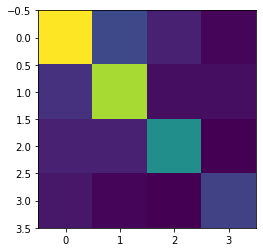

In [ ]:
# without schedular
lr=3.714160131899854e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_3, predictions_3, true_vals_3, dataloader_test_3, model_3 = run_model()

In [ ]:
# with schedular
# lr=3.714160131899854e-06
# optimizer_choice='AdamW'
# eps=1e-8
# number_of_epochs=8
# batch_size=16


save_path = '/content/drive/MyDrive/Stance Detection/Own/'
# import joblib
# joblib.dump(whole_configurations, save_path +"whole_configurations6.pkl")
joblib.dump(training_status_sch, save_path +"whole_training_status_au_insertion_sch_lr-e6_ep8_bs16.pkl")
joblib.dump(predictions_sch, save_path +"whole_validation_predictions_au_insertion_sch_lr-e6_ep8_bs16.pkl")
joblib.dump(true_vals_sch, save_path +"whole_true_values_au_insertion_sch_lr-e6_ep8_bs16.pkl")
joblib.dump(dataloader_test_sch, save_path +"whole_test_dataloaders_au_insertion_sch_lr-e6_ep8_bs16.pkl")
joblib.dump(model_sch, save_path +"whole_final_model_au_insertion_sch_lr-e6_ep8_bs16.pkl")

['/content/drive/MyDrive/Stance Detection/Own/whole_final_model_au_insertion_sch_lr-e6_ep8_bs16.pkl']

In [ ]:
# with schedular
# lr=3.714160131899854e-06
# optimizer_choice='AdamW'
# eps=1e-8
# number_of_epochs=6
# batch_size=16


save_path = '/content/drive/MyDrive/Stance Detection/Own/'
# import joblib
# joblib.dump(whole_configurations, save_path +"whole_configurations6.pkl")
joblib.dump(training_status_sch_2, save_path +"whole_training_status_au_insertion_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(predictions_sch_2, save_path +"whole_validation_predictions_au_insertion_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(true_vals_sch_2, save_path +"whole_true_values_au_insertion_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(dataloader_test_sch_2, save_path +"whole_test_dataloaders_au_insertion_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(model_sch_2, save_path +"whole_final_model_au_insertion_sch_lr-e6_ep6_bs16.pkl")

['/content/drive/MyDrive/Stance Detection/Own/whole_final_model_au_insertion_sch_lr-e6_ep6_bs16.pkl']

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 16, 'Learning rate': 3.714160131899854e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.2872397815338288
Validation loss: 1.0886811649098116
Training eval Acc.: 0.5489576753000631
Validation Acc.: 0.5521235521235521
Training eval F1 Score (Weighted): 0.450774088216817
Validation F1 Score (Weighted): 0.4661660008480818
Training this epoch took: 0:00:31


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 1.028144445082154
Validation loss: 0.8643125751439262
Training eval Acc.: 0.7580543272267846
Validation Acc.: 0.6718146718146718
Training eval F1 Score (Weighted): 0.7548180723306864
Validation F1 Score (Weighted): 0.6624490510968998
Training this epoch took: 0:00:31


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.7522867192523648
Validation loss: 0.7475933695540709
Training eval Acc.: 0.8382817435249527
Validation Acc.: 0.6911196911196911
Training eval F1 Score (Weighted): 0.8378344122579942
Validation F1 Score (Weighted): 0.6903399186364148
Training this epoch took: 0:00:31


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.5758415003015538
Validation loss: 0.7024907105985809
Training eval Acc.: 0.8793430195830702
Validation Acc.: 0.7181467181467182
Training eval F1 Score (Weighted): 0.8797815942363916
Validation F1 Score (Weighted): 0.7173146687384234
Training this epoch took: 0:00:31


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.45055832480541386
Validation loss: 0.7063950190649313
Training eval Acc.: 0.919772583701832
Validation Acc.: 0.722007722007722
Training eval F1 Score (Weighted): 0.9197889438684356
Validation F1 Score (Weighted): 0.7214335153288809
Training this epoch took: 0:00:31


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.341865914563338
Validation loss: 0.7104866515625926
Training eval Acc.: 0.9475679090334808
Validation Acc.: 0.7451737451737451
Training eval F1 Score (Weighted): 0.9476218392576181
Validation F1 Score (Weighted): 0.7451913564653226
Training this epoch took: 0:00:31


Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.24821365812812188
Validation loss: 0.7364166536751915
Training eval Acc.: 0.9658875552747946
Validation Acc.: 0.7683397683397684
Training eval F1 Score (Weighted): 0.9659239566855913
Validation F1 Score (Weighted): 0.7684670862029352
Training this epoch took: 0:00:31


Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.20167805920496132
Validation loss: 0.7573782000690699
Training eval Acc.: 0.9785217940619078
Validation Acc.: 0.7567567567567568
Training eval F1 Score (Weighted): 0.9785164822549604
Validation F1 Score (Weighted): 0.7567236605787729
Training this epoch took: 0:00:31
Training Done!
Total training took 0:05:11 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




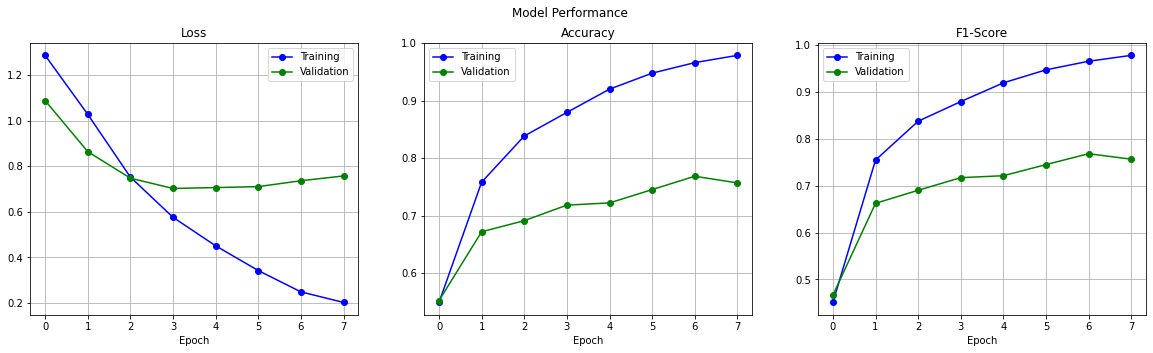

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 74/102

Class: Unrelated
Accuracy: 67/84

Class: Agree
Accuracy: 41/52

Class: Disagree
Accuracy: 14/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.73      0.77       102
           1       0.73      0.80      0.76        84
           2       0.72      0.79      0.75        52
           3       0.74      0.67      0.70        21

    accuracy                           0.76       259
   macro avg       0.75      0.74      0.75       259
weighted avg       0.76      0.76      0.76       259

************************

Confusion Matrix: 

[[74 18  7  3]
 [ 8 67  7  2]
 [ 4  7 41  0]
 [ 5  0  2 14]]


loss on test set:  0.8487654566764832
f1 on test set:  0.7409293336765288
acc on test set:  0.740983606557377


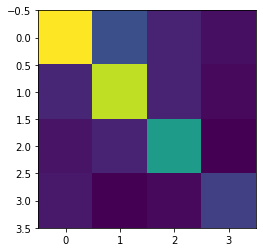

In [ ]:
# without schedular
lr=3.714160131899854e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status, predictions, true_vals, dataloader_test, model = run_model()

In [ ]:
save_path = '/content/drive/MyDrive/Stance Detection/Own/'
# import joblib
# joblib.dump(whole_configurations, save_path +"whole_configurations6.pkl")
joblib.dump(training_status, save_path +"whole_training_status_au_insertion_lr-e6_ep8_bs16_2.pkl")
joblib.dump(predictions, save_path +"whole_validation_predictions_au_insertion_lr-e6_ep8_bs16_2.pkl")
joblib.dump(true_vals, save_path +"whole_true_values_au_insertion_lr-e6_ep8_bs16_2.pkl")
joblib.dump(dataloader_test, save_path +"whole_test_dataloaders_au_insertion_lr-e6_ep8_bs16_2.pkl")
# joblib.dump(model_sch, save_path +"whole_final_model_au_insertion_sch_lr-e6_ep8_bs16_2.pkl")

['/content/drive/MyDrive/Stance Detection/Own/whole_test_dataloaders_au_insertion_lr-e6_ep8_bs16_2.pkl']

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 16, 'Learning rate': 3.714160131899854e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!
Schedular is set!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.2299352511010988
Validation loss: 1.0582023718777824
Training eval Acc.: 0.5647504737839545
Validation Acc.: 0.555984555984556
Training eval F1 Score (Weighted): 0.46051781793797997
Validation F1 Score (Weighted): 0.46880472032738174
Training this epoch took: 0:00:31


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 1.0662007988101305
Validation loss: 1.0011791481691248
Training eval Acc.: 0.593177511054959
Validation Acc.: 0.5675675675675675
Training eval F1 Score (Weighted): 0.4882625562844997
Validation F1 Score (Weighted): 0.4793479193479193
Training this epoch took: 0:00:31


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.9556200450116937
Validation loss: 0.9606810527689317
Training eval Acc.: 0.6121288692356286
Validation Acc.: 0.5791505791505791
Training eval F1 Score (Weighted): 0.504493723535764
Validation F1 Score (Weighted): 0.4890026463060171
Training this epoch took: 0:00:31


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.8476487253651475
Validation loss: 0.8722419440746307
Training eval Acc.: 0.7182564750473784
Validation Acc.: 0.6640926640926641
Training eval F1 Score (Weighted): 0.6847972642326109
Validation F1 Score (Weighted): 0.6301447960666172
Training this epoch took: 0:00:31


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.7274180759083141
Validation loss: 0.793731722761603
Training eval Acc.: 0.8250157927984839
Validation Acc.: 0.7297297297297297
Training eval F1 Score (Weighted): 0.8240982587416676
Validation F1 Score (Weighted): 0.7280557018767014
Training this epoch took: 0:00:31


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.6285956736766931
Validation loss: 0.7502538789721096
Training eval Acc.: 0.85028427037271
Validation Acc.: 0.7258687258687259
Training eval F1 Score (Weighted): 0.8497043630855068
Validation F1 Score (Weighted): 0.7246896695911685
Training this epoch took: 0:00:31


Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.557150641475061
Validation loss: 0.7358760658432456
Training eval Acc.: 0.8679722046746684
Validation Acc.: 0.7297297297297297
Training eval F1 Score (Weighted): 0.8682500235934396
Validation F1 Score (Weighted): 0.7289869415292296
Training this epoch took: 0:00:31


Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.5361981434051437
Validation loss: 0.7298680228345534
Training eval Acc.: 0.8679722046746684
Validation Acc.: 0.7258687258687259
Training eval F1 Score (Weighted): 0.8684819124088436
Validation F1 Score (Weighted): 0.7251718709000262
Training this epoch took: 0:00:31
Training Done!
Total training took 0:05:11 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




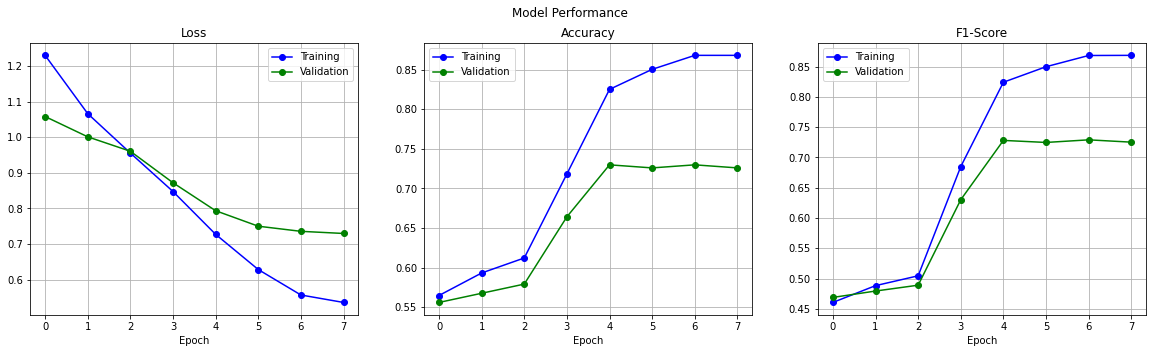

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 73/102

Class: Unrelated
Accuracy: 66/84

Class: Agree
Accuracy: 36/52

Class: Disagree
Accuracy: 13/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       102
           1       0.73      0.79      0.75        84
           2       0.71      0.69      0.70        52
           3       0.68      0.62      0.65        21

    accuracy                           0.73       259
   macro avg       0.72      0.70      0.71       259
weighted avg       0.73      0.73      0.73       259

************************

Confusion Matrix: 

[[73 17  8  4]
 [ 9 66  7  2]
 [ 8  8 36  0]
 [ 8  0  0 13]]


loss on test set:  0.8226522266864776
f1 on test set:  0.7144480622631542
acc on test set:  0.7147540983606557


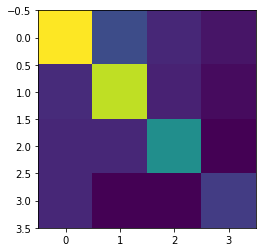

In [ ]:
# with schedular
lr=3.714160131899854e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_sch, predictions_sch, true_vals_sch, dataloader_test_sch, model_sch = run_model()

In [ ]:
save_path = '/content/drive/MyDrive/Stance Detection/Own/'
# import joblib
# joblib.dump(whole_configurations, save_path +"whole_configurations6.pkl")
joblib.dump(training_status_sch, save_path +"whole_training_status_au_insertion_sch_lr-e6_ep8_bs16_2.pkl")
joblib.dump(predictions_sch, save_path +"whole_validation_predictions_au_insertion_sch_lr-e6_ep8_bs16_2.pkl")
joblib.dump(true_vals_sch, save_path +"whole_true_values_au_insertion_sch_lr-e6_ep8_bs16_2.pkl")
joblib.dump(dataloader_test_sch, save_path +"whole_test_dataloaders_au_insertion_sch_lr-e6_ep8_bs16_2.pkl")
# joblib.dump(model_sch, save_path +"whole_final_model_au_insertion_sch_lr-e6_ep8_bs16_2.pkl")

['/content/drive/MyDrive/Stance Detection/Own/whole_test_dataloaders_au_insertion_sch_lr-e6_ep8_bs16_2.pkl']